In [21]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [22]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [23]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 16.2MB/s eta 0:00:01


In [24]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [25]:
#加载飞桨和相关类库

import paddle
from paddle.vision.transforms import Compose, Normalize
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

In [26]:
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear, Dropout

class InceptionA(paddle.nn.Layer):
    def __init__(self,in_channels):
        super(InceptionA,self).__init__()
        self.branch1x1=Conv2D(in_channels,16,kernel_size=1)

        self.branch5x5_1=Conv2D(in_channels,16,kernel_size=1)
        self.branch5x5_2=Conv2D(16,24,kernel_size=5,padding=2)

        self.branch3x3_1=Conv2D(in_channels,16,kernel_size=1)
        self.branch3x3_2=Conv2D(16,24,kernel_size=3,padding=1)
        self.branch3x3_3=Conv2D(24,24,kernel_size=3,padding=1)

        self.branch_pool=Conv2D(in_channels,24,kernel_size=1)

    def forward(self,x):
        branch1x1=self.branch1x1(x)

        branch5x5=self.branch5x5_1(x)
        branch5x5=self.branch5x5_2(branch5x5)

        branch3x3=self.branch3x3_1(x)
        branch3x3=self.branch3x3_2(branch3x3)
        branch3x3=self.branch3x3_3(branch3x3)

        branch_pool=F.avg_pool2d(x,kernel_size=3,stride=1,padding=1)
        branch_pool=self.branch_pool(branch_pool)

        outputs=[branch1x1,branch5x5,branch3x3,branch_pool]
        return paddle.concat(outputs,1)   #横着拼接

class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST,self).__init__()
        self.conv1=Conv2D(1,10,kernel_size=1)
        self.conv2=Conv2D(88,20,kernel_size=5)

        self.inception1=InceptionA(in_channels=10)
        self.inception2=InceptionA(in_channels=20)

        self.maxpool=MaxPool2D(2)
        self.fc=Linear(2200,10)      #5*5*88=2200

    def forward(self,x,label):
        x=F.relu(self.maxpool(self.conv1(x)))    #图像尺寸14*14
        x=self.inception1(x)                    #图像尺寸14*14
        x=F.relu(self.maxpool(self.conv2(x)))    #图像尺寸5*5
        x=self.inception2(x)                    #图像尺寸5*5
        x = paddle.reshape(x, [x.shape[0], 88*5*5])           #88*5*5  展平成一维
        x=self.fc(x)
        if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
        else:
             return x

In [27]:
import paddle

transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])# 归一化

train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

In [28]:
def train(model):
    model = MNIST()
    model.train()

    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(train_dataset, 
                                        batch_size=64, 
                                        shuffle=True)
    # 定义优化器，使用ADM优化器，学习率设置为0.001
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    losss = []
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
                
            #后向传播，更新参数，消除梯度的过程
            avg_loss.backward()#反向传播计算梯度
            opt.step()#通过梯度更新网络参数
            opt.clear_grad()#梯度清除，进入下一次训练

            if batch_id % 200 == 0:
                losss.append(float(avg_loss.numpy()))

        
        #每训练完一周期，打印下当前Loss的情况
        print("epoch: {}, loss is: {}, acc is {}".format(epoch_id, avg_loss.numpy(), acc.numpy()))
        #print("epoch: {}， loss is: {}".format(epoch_id, loss.numpy()))

    plt.figure()
    xlab = np.linspace(1, len(losss), len(losss))
    plt.xlabel('iterations')
    plt.ylabel('average loss')
    plt.plot(xlab, losss, 'r')

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')





In [29]:
def test(model):

    # 加载测试集 batch_size 设为 64
    test_loader = paddle.io.DataLoader(test_dataset, 
                                        batch_size=16, 
                                        shuffle=True)
    # 加载模型参数
    param_dict = paddle.load('mnist.pdparams')
    model.load_dict(param_dict)

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(test_loader()):
        #准备数据
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))

        
        
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()
    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

    

epoch: 0, loss is: [0.2254697], acc is [0.9375]
epoch: 1, loss is: [0.12235742], acc is [0.9375]
epoch: 2, loss is: [0.04085634], acc is [0.96875]
epoch: 3, loss is: [0.05429631], acc is [0.96875]
epoch: 4, loss is: [0.07239434], acc is [0.96875]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


loss=0.10900526230284013, acc=0.965


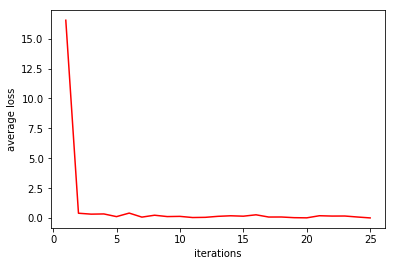

In [30]:
#创建模型    
model = MNIST()
#启动训练过程
train(model)
#启动测试过程
test(model)